resources

- xarray pipeline example: https://github.com/openclimatefix/ocf_datapipes/blob/main/ocf_datapipes/training/pv_satellite_nwp.py
- https://discourse.pangeo.io/t/efficiently-slicing-random-windows-for-reduced-xarray-dataset/2447
- https://medium.com/speechmatics/how-to-build-a-streaming-dataloader-with-pytorch-a66dd891d9ddhttps://medium.com/speechmatics/how-to-build-a-streaming-dataloader-with-pytorch-a66dd891d9dd
- https://zen3geo.readthedocs.io/en/latest/chipping.htmlhttps://zen3geo.readthedocs.io/en/latest/chipping.html

In [1]:
# doesn't work:
#!pip install git+https://github.com/pytorch/data.git@9d91c666534633e94c71a248b839aef227adf5d1

In [2]:
%load_ext lab_black

In [3]:
import zen3geo
import xarray as xr
from torchdata.datapipes.iter import IterableWrapper
import torchdata.datapipes.utils
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchdata

torchdata.__version__, torch.__version__

('0.6.0.dev20221214', '2.0.0.dev20221214+cpu')

In [4]:
# based on https://github.com/weiji14/zen3geo/blob/main/zen3geo/datapipes/rioxarray.py

from torchdata.datapipes import functional_datapipe
from torchdata.datapipes.iter import IterDataPipe
from torchdata.datapipes.utils import StreamWrapper
from typing import Union
from typing import Any, Dict, Iterator, Optional
from pathlib import Path


@functional_datapipe("open_xarray_dataset")
class OpenXarrayDatasetIterDataPipe(IterDataPipe[StreamWrapper]):
    """ """

    _xr_open_method = xr.open_dataset

    def __init__(
        self, source_datapipe: IterDataPipe[str], **kwargs: Optional[Dict[str, Any]]
    ) -> None:
        self.source_datapipe: IterDataPipe[str] = source_datapipe
        self.kwargs = kwargs

    def __iter__(self) -> Iterator[StreamWrapper]:
        for filename in self.source_datapipe:
            # getting attribute via __class__ avoids `self` being passed in when we call the function
            yield StreamWrapper(self.__class__._xr_open_method(filename, **self.kwargs))

    def __len__(self) -> int:
        return len(self.source_datapipe)


@functional_datapipe("open_xarray_dataarray")
class OpenXarrayDataArrayIterDataPipe(OpenXarrayDatasetIterDataPipe):
    _xr_open_method = xr.open_dataarray

In [5]:
def xr_collate_fn(samples) -> torch.Tensor:
    """
    Converts individual xarray.DataArray objects to a torch.Tensor (float32
    dtype), and stacks them all into a single torch.Tensor.
    """
    tensors = [
        torch.as_tensor(data=sample.squeeze().data.astype(dtype="float32"))
        for sample in samples
    ]
    return torch.stack(tensors=tensors)

In [6]:
filepaths = [
    "rico.no_shear_br0.05.qv.tn6.nc",
]

In [7]:
tile_size = 128
dp = (
    IterableWrapper(filepaths)
    .open_xarray_dataarray()
    .slice_with_xbatcher(input_dims=dict(xt=tile_size, yt=1, zt=tile_size))
    .batch(batch_size=2)
    .map(xr_collate_fn)
)

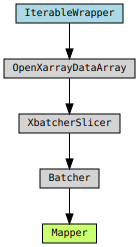

In [8]:
torchdata.datapipes.utils.to_graph(dp=dp)

In [9]:
next(iter(dp)).size()  # .squeeze()  # .plot()

torch.Size([2, 128, 128])

In [10]:
dp.batch

functools.partial(<function IterDataPipe.register_datapipe_as_function.<locals>.class_function at 0x7fda4c036f70>, <class 'torch.utils.data.datapipes.iter.grouping.BatcherIterDataPipe'>, False, MapperIterDataPipe)

## Normalization

- https://github.com/openclimatefix/ocf_datapipes/blob/main/ocf_datapipes/utils/consts.py

In [11]:
tile_size = 128
dp = IterableWrapper(filepaths).open_xarray_dataarray()

In [12]:
# I'm sure there are better ways of doing this, but how?


def aggregate_mean(stream):
    return xr.concat([item.file_obj for item in stream], dim="sample").mean()


def aggregate_std(stream):
    return xr.concat([item.file_obj for item in stream], dim="sample").std()


mean_global = next(iter(dp.zip().map(aggregate_mean))).item()
std_global = next(iter(dp.zip().map(aggregate_std))).item()

In [13]:
# based on https://github.com/openclimatefix/ocf_datapipes/blob/c317817bd207237a9cd5943f804cecb786f894a9/ocf_datapipes/transform/xarray/normalize.py

import logging
from typing import Callable, Optional, Union

import numpy as np
import xarray as xr
from torchdata.datapipes import functional_datapipe
from torchdata.datapipes.iter import IterDataPipe


@functional_datapipe("normalize_xr")
class NormalizeIterDataPipe(IterDataPipe):
    """Normalize the data with set of fixed mean and std values"""

    def __init__(
        self,
        source_datapipe: IterDataPipe,
        mean: Union[xr.Dataset, xr.DataArray, np.ndarray],
        std: Union[xr.Dataset, xr.DataArray, np.ndarray],
    ):
        self.source_datapipe = source_datapipe
        self.mean = mean
        self.std = std

    def __iter__(self) -> Union[xr.Dataset, xr.DataArray]:
        for xr_data in self.source_datapipe:
            long_name = xr_data.long_name
            xr_data = xr_data - self.mean
            xr_data = xr_data / self.std
            xr_data.attrs["long_name"] = f"Normalized {long_name}"
            xr_data.attrs["units"] = "1"
            yield xr_data

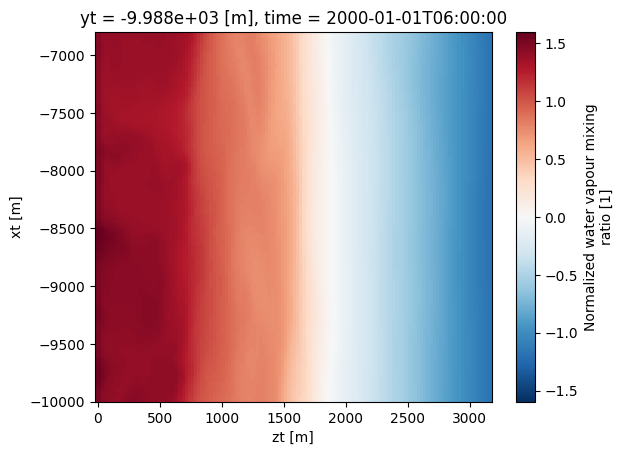

In [14]:
tile_size = 128
dp = (
    IterableWrapper(filepaths)
    .open_xarray_dataarray()
    .slice_with_xbatcher(input_dims=dict(xt=tile_size, yt=1, zt=tile_size))
    .normalize_xr(std=std_global, mean=mean_global)
    # .batch(batch_size=2)
    # .map(xr_collate_fn)
)
next(iter(dp)).plot()

## adding noise

https://github.com/COMP6248-Reproducability-Challenge/selfsupervised-denoising

```
N2C: (noisy, clean)
N2N: (noisy1, noisy2)
N2V: (noisy, noisy)
SSDN: (noisy,)
```

In [15]:
def add_noise(da):
    sigma = 0.2
    noise = np.random.normal(scale=sigma, size=da.shape)
    da_noisy = da + noise
    da_noisy.attrs["long_name"] = f"{da.long_name} with added noise"
    da_noisy.attrs["units"] = da.units
    return da_noisy


def add_noisy_copy(da):
    return da, add_noise(da)


def create_two_noisy_copies(da):
    return add_noise(da), add_noise(da)

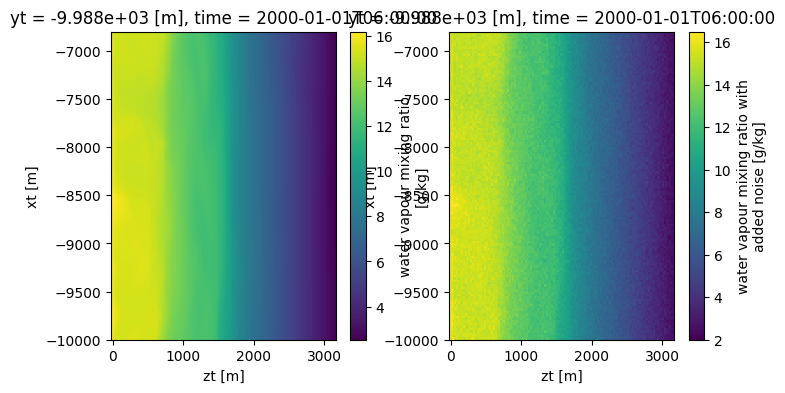

In [16]:
tile_size = 128


def pipeline_augmentationfor_model(model_name):
    if model_name == "n2n":
        return add_noisy_copy
    elif model_name == "n2v":
        return create_two_noisy_copies
    elif model_name == "ssdn":
        return lambda da: (add_noise(da),)
    else:
        raise NotImplementedError(model_name)


tile_size = 128
dp = (
    IterableWrapper(filepaths)
    .open_xarray_dataarray()
    .slice_with_xbatcher(input_dims=dict(xt=tile_size, yt=1, zt=tile_size))
    .map(pipeline_augmentationfor_model(model_name="n2n"))
    # .batch(batch_size=2)
    # .map(xr_collate_fn)
)

fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
for ax, da_sample in zip(axes, next(iter(dp))):
    da_sample.plot(ax=ax)

In [17]:
# add IterDataPipe


@functional_datapipe("xr_add_noise")
class AddNoiseIterDataPipe(IterDataPipe):
    def __init__(self, source_datapipe: IterDataPipe[str], sigma=0.2) -> None:
        self.source_datapipe: IterDataPipe[str] = source_datapipe
        self.sigma = sigma

    def __iter__(self) -> Iterator[StreamWrapper]:
        for da in self.source_datapipe:
            sigma = 0.2
            noise = np.random.normal(scale=self.sigma, size=da.shape)
            da_noisy = da + noise
            da_noisy.attrs["long_name"] = f"{da.long_name} with added noise"
            da_noisy.attrs["units"] = da.units
            yield da_noisy

    def __len__(self) -> int:
        return len(self.source_datapipe)

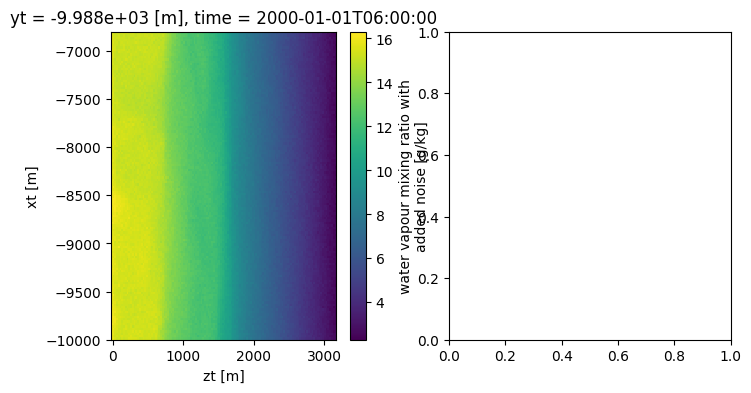

In [19]:
tile_size = 128
dp = (
    IterableWrapper(filepaths)
    .open_xarray_dataarray()
    .slice_with_xbatcher(input_dims=dict(xt=tile_size, yt=1, zt=tile_size))
    .xr_add_noise(sigma=0.1)
    # .batch(batch_size=2)
    # .map(xr_collate_fn)
)

fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
for ax, da_sample in zip(axes, next(iter(dp))):
    da_sample.plot(ax=ax)

## using forking of datapipe

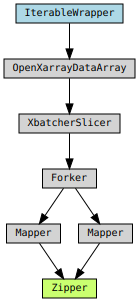

In [19]:
def augment_pipeline_for_model(dp, model_name):
    if model_name == "n2n":
        return dp.map(add_noise)
    elif model_name == "n2v":
        dp1, dp2 = dp.fork(num_instances=2)
        # need to normalize each othese too... this seems messy
        dp1 = dp1.map(add_noise)
        dp2 = dp2.map(add_noise)
        return dp1.zip(dp2)
    elif model_name == "ssdn":
        return dp.map(add_noise)
    else:
        raise NotImplementedError(model_name)


dp = (
    IterableWrapper(filepaths)
    .open_xarray_dataarray()
    .slice_with_xbatcher(input_dims=dict(xt=tile_size, yt=1, zt=tile_size))
)

dp = augment_pipeline_for_model(dp, "n2v")

torchdata.datapipes.utils.to_graph(dp)

# full pipeline

## per-model pipeline

### N2C


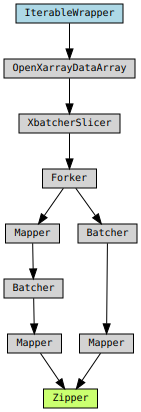

In [22]:
tile_size = 128
dp_clean, dp_noisy = (
    IterableWrapper(filepaths)
    .open_xarray_dataarray()
    .slice_with_xbatcher(input_dims=dict(xt=tile_size, yt=1, zt=tile_size))
    .fork(num_instances=2)
)
batch_size = 4
dp_noisy = dp_noisy.map(add_noise).batch(batch_size=batch_size).map(xr_collate_fn)
dp_clean = dp_clean.batch(batch_size=batch_size).map(xr_collate_fn)
dp = dp_clean.zip(dp_noisy)

torchdata.datapipes.utils.to_graph(dp)

In [23]:
item = next(iter(dp))
item

(tensor([[[15.7927, 15.7927, 15.4304,  ...,  2.7658,  2.6756,  2.5962],
          [15.7789, 15.7789, 15.4283,  ...,  2.7659,  2.6759,  2.5966],
          [15.7794, 15.7794, 15.4366,  ...,  2.7663,  2.6764,  2.5973],
          ...,
          [15.4871, 15.4871, 15.2617,  ...,  2.7552,  2.6567,  2.5729],
          [15.4601, 15.4601, 15.2663,  ...,  2.7500,  2.6523,  2.5694],
          [15.4466, 15.4466, 15.2804,  ...,  2.7447,  2.6479,  2.5661]],
 
         [[15.8085, 15.8085, 15.4343,  ...,  2.7677,  2.6773,  2.5974],
          [15.7836, 15.7836, 15.4236,  ...,  2.7677,  2.6774,  2.5978],
          [15.7662, 15.7662, 15.4225,  ...,  2.7678,  2.6777,  2.5983],
          ...,
          [15.5486, 15.5486, 15.2910,  ...,  2.7595,  2.6603,  2.5758],
          [15.5320, 15.5320, 15.3027,  ...,  2.7544,  2.6561,  2.5725],
          [15.5219, 15.5219, 15.3240,  ...,  2.7493,  2.6519,  2.5692]],
 
         [[15.8050, 15.8050, 15.4332,  ...,  2.7697,  2.6790,  2.5988],
          [15.7763, 15.7763,

### N2N

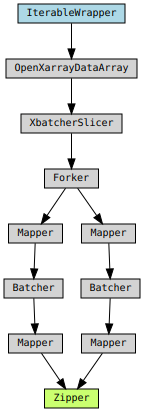

In [24]:
tile_size = 128
dp_noisy1, dp_noisy2 = (
    IterableWrapper(filepaths)
    .open_xarray_dataarray()
    .slice_with_xbatcher(input_dims=dict(xt=tile_size, yt=1, zt=tile_size))
    .fork(num_instances=2)
)
batch_size = 4
dp_noisy1 = dp_noisy1.map(add_noise).batch(batch_size=batch_size).map(xr_collate_fn)
dp_noisy2 = dp_noisy2.map(add_noise).batch(batch_size=batch_size).map(xr_collate_fn)
dp = dp_noisy1.zip(dp_noisy2)

torchdata.datapipes.utils.to_graph(dp)

### SSDN

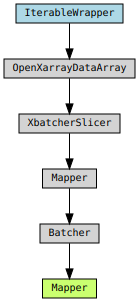

In [25]:
tile_size = 128
dp = (
    IterableWrapper(filepaths)
    .open_xarray_dataarray()
    .slice_with_xbatcher(input_dims=dict(xt=tile_size, yt=1, zt=tile_size))
    .map(add_noise)
    .batch(batch_size=batch_size)
    .map(xr_collate_fn)
)

torchdata.datapipes.utils.to_graph(dp)

### common

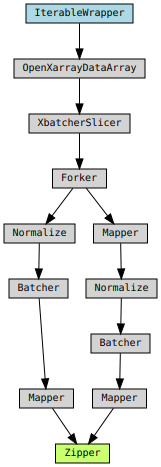

In [39]:
tile_size = 128


def create_benchmarking_pipeline(filepaths, model_name, tile_size=128, batch_size=16):
    dp_chipped_input = (
        IterableWrapper(filepaths)
        .open_xarray_dataarray()
        .slice_with_xbatcher(input_dims=dict(xt=tile_size, yt=1, zt=tile_size))
    )

    if model_name == "n2c":
        dp_clean, dp_noisy = dp_chipped_input.fork(num_instances=2)
        dp_noisy = dp_noisy.map(add_noise)
        dps = [dp_clean, dp_noisy]
    elif model_name == "n2n":
        dp_noisy1, dp_noisy2 = dp_chipped_input.fork(num_instances=2)
        dp_noisy1 = dp_noisy1.map(add_noise)
        dp_noisy2 = dp_noisy2.map(add_noise)
        dps = [dp_noisy1, dp_noisy2]
    elif model_name == "ssdn":
        dp_noisy = dp_chipped_input.map(add_noise)
        dps = [dp_noisy]
    else:
        raise NotImplementedError(model_name)

    for i in range(len(dps)):
        dps[i] = (
            dps[i]
            .normalize_xr(std=std_global, mean=mean_global)
            .batch(batch_size=batch_size)
            .map(xr_collate_fn)
        )

    if len(dps) > 1:
        dp = dps[0].zip(*dps[1:])
    else:
        dp = dps[0]

    return dp


dp = create_benchmarking_pipeline(filepaths, model_name="n2c", batch_size=2)
torchdata.datapipes.utils.to_graph(dp)

# train-test split

In [67]:
def create_training_benchmark_pipeline(
    filepaths,
    model_name,
    n_samples=100,
    train_test_split=0.9,
    tile_size=128,
    batch_size=16,
    seed=42,
):
    dp = create_benchmarking_pipeline(
        filepaths=filepaths,
        model_name=model_name,
        tile_size=tile_size,
        batch_size=batch_size,
    )
    return dp.header(n_samples).random_split(
        weights=dict(train=train_test_split, test=1.0 - train_test_split),
        seed=seed,
        total_length=n_samples,
    )


dp_train, dp_test = create_training_benchmark_pipeline(
    filepaths, model_name="n2c", batch_size=2
)

n = 0
for item in dp_train:
    n += 1

print(n)

90


In [29]:
tile_size = 128
dp = (
    IterableWrapper(filepaths)
    .open_xarray_dataarray()
    .slice_with_xbatcher(input_dims=dict(xt=tile_size, yt=1, zt=tile_size))
    .random_split(seed=42, weights=)
)

TypeError: __new__() missing 1 required positional argument: 'weights'

In [58]:
dp = IterableWrapper(range(10))
train, valid = dp.random_split(
    total_length=5, weights={"train": 0.5, "valid": 0.5}, seed=0
)
list(train)

ValueError: Total of weights must be greater than zero
This exception is thrown by __iter__ of SplitterIterator(main_datapipe=_RandomSplitterIterDataPipe, target='train')